In [1]:
import os
import xrft
import numpy as np
import torch
from tqdm import tqdm
from dataset import Agulhas
from Pix2Pix import Generator
from utils import load_checkpoint, plot_examples
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

In [2]:
MODEL = 'PIX2PIX03'
LEARNING_RATE = 2.0e-4
RESTORE_FROM = os.path.join(MODEL, 'snapshots', 'epoch-50')

In [3]:
dataset = Agulhas(split='val', joint_transform=None)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False, drop_last=False)

trans_params = dict()
trans_params['inputs_mean'] = dataset.inputs_mean_std[0]
trans_params['inputs_std'] = dataset.inputs_mean_std[1]
trans_params['targets_mean'] = dataset.targets_mean_std[0]
trans_params['targets_std'] = dataset.targets_mean_std[1]

In [4]:
cudnn.enabled = True
cudnn.benchmark = True

model = Generator(in_channels=1, features=64).cuda()
load_checkpoint(f'{RESTORE_FROM}/generator.pth', model, None, None)

Loading Checkpoint...


In [5]:
model.eval()
inps = np.empty((0, 1, 256, 256))
tars = np.empty((0, 1, 256, 256))
gens = np.empty((0, 1, 256, 256))

with torch.no_grad():
    
    loop = tqdm(dataloader, leave=True)
    for counter, (x, y) in enumerate(loop, 1):

        # GPU deployment
        x = x.cuda()
        y = y.cuda()

        # Compute prediction and loss
        g = model(x)
        
        inps = np.concatenate((inps, x.detach().cpu().numpy() * trans_params['inputs_std'] + trans_params['inputs_mean']), axis=0)
        tars = np.concatenate((tars, y.detach().cpu().numpy() * trans_params['targets_std'] + trans_params['targets_mean']), axis=0)
        gens = np.concatenate((gens, g.detach().cpu().numpy() * trans_params['targets_std'] + trans_params['targets_mean']) , axis=0)

print(inps.shape, tars.shape, gens.shape)   

100%|██████████| 413/413 [00:56<00:00,  7.35it/s]

(413, 1, 256, 256) (413, 1, 256, 256) (413, 1, 256, 256)


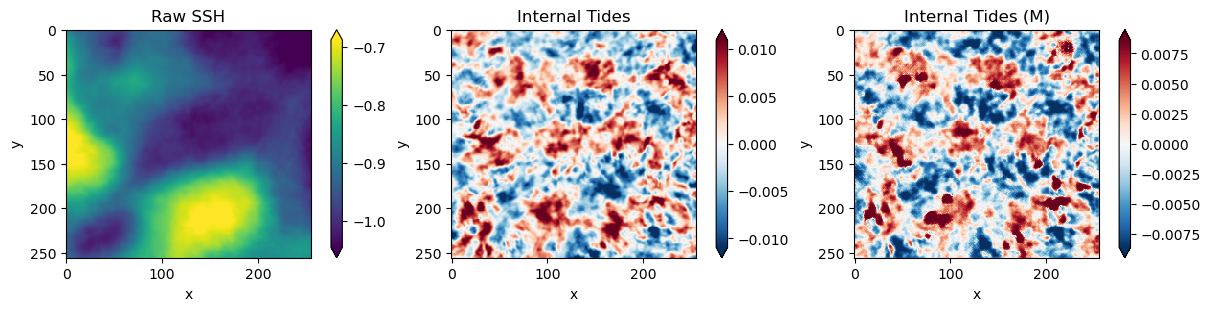

In [18]:
idx = 1
plot_examples(inps[idx], tars[idx], gens[idx])

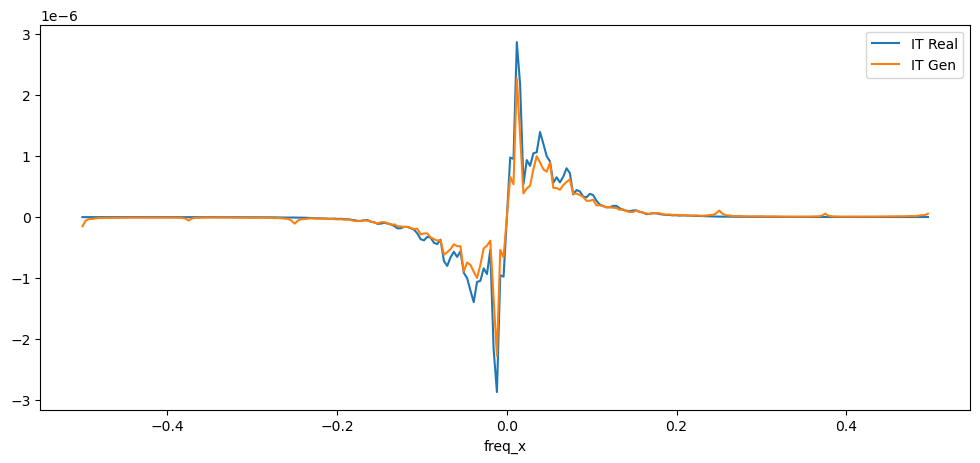

In [20]:
import xarray as xr
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))

da_raw = xr.DataArray(inps[idx].squeeze(), dims=['x', 'y'])
da_itr = xr.DataArray(tars[idx].squeeze(), dims=['x', 'y'])
da_itg = xr.DataArray(gens[idx].squeeze(), dims=['x', 'y'])

ps_raw = xrft.power_spectrum(da_raw, 'x', window='hamming').rename('raw')
ps_itr = xrft.power_spectrum(da_itr, 'x', window='hamming').rename('raw')
ps_itg = xrft.power_spectrum(da_itg, 'x', window='hamming').rename('raw')

# (ps_raw * ps_raw.freq_x).mean('y').plot(label='Raw SSH', ax=ax)
(ps_itr * ps_itr.freq_x).mean('y').plot(label='IT Real', ax=ax)
(ps_itg * ps_itg.freq_x).mean('y').plot(label='IT Gen', ax=ax)

plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(tars[idx].ravel(), gens[idx].ravel(), squared=False)
print(mse)

0.0032229035698331946


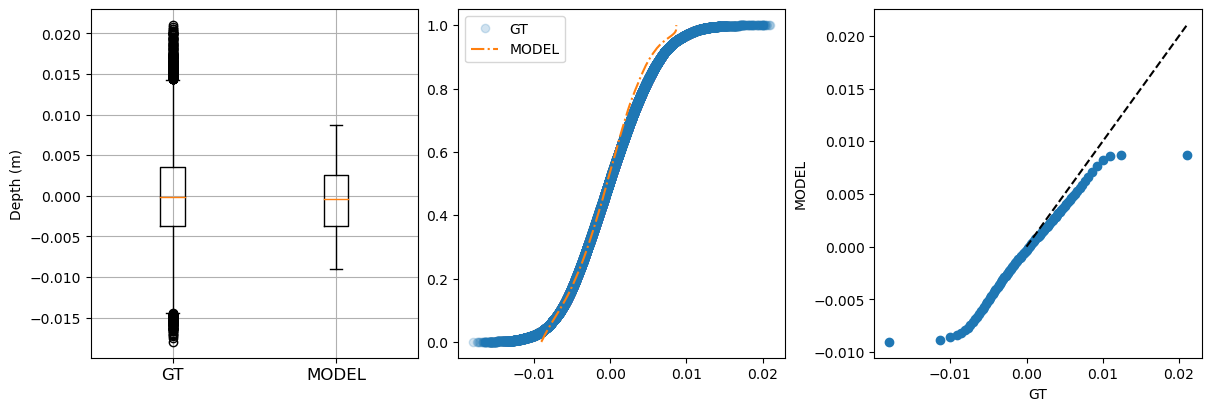

In [23]:
qqplot(tars[idx].ravel(), gens[idx].ravel(), quantiles=100)

In [30]:
# Generating ITs
model.eval()
its_inp = np.empty((0, 1, 256, 256))
its_gen = np.empty((0, 1, 256, 256))


with torch.no_grad():
    
    loop = tqdm(dataloader, leave=True)
    for counter, (_, y) in enumerate(loop, 1):

        # GPU deployment
        y = y.cuda()

        # Compute prediction and loss
        g = model(y)
        
        its_inp = np.concatenate((its_inp, y.detach().cpu().numpy() * trans_params['targets_std'] + trans_params['targets_mean']), axis=0)
        its_gen = np.concatenate((its_gen, g.detach().cpu().numpy() * trans_params['targets_std'] + trans_params['targets_mean']) , axis=0)

100%|██████████| 413/413 [00:38<00:00, 10.71it/s]


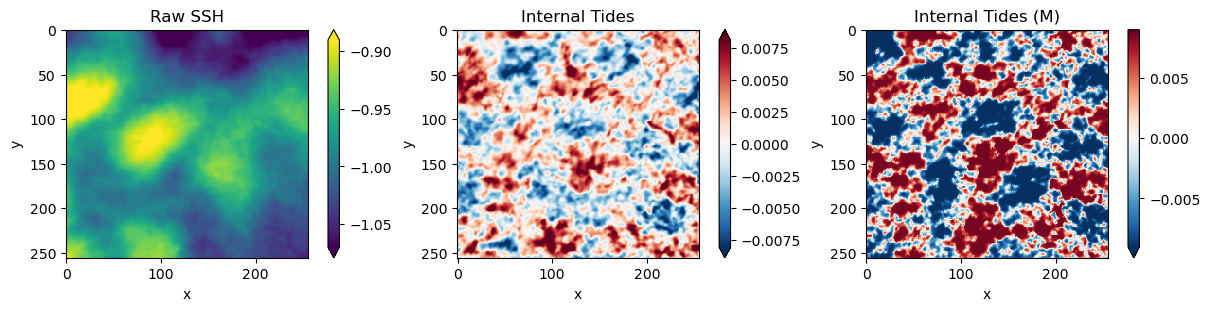

In [31]:
idx = 0
plot_examples(inps[idx], its_inp[idx], its_gen[idx])

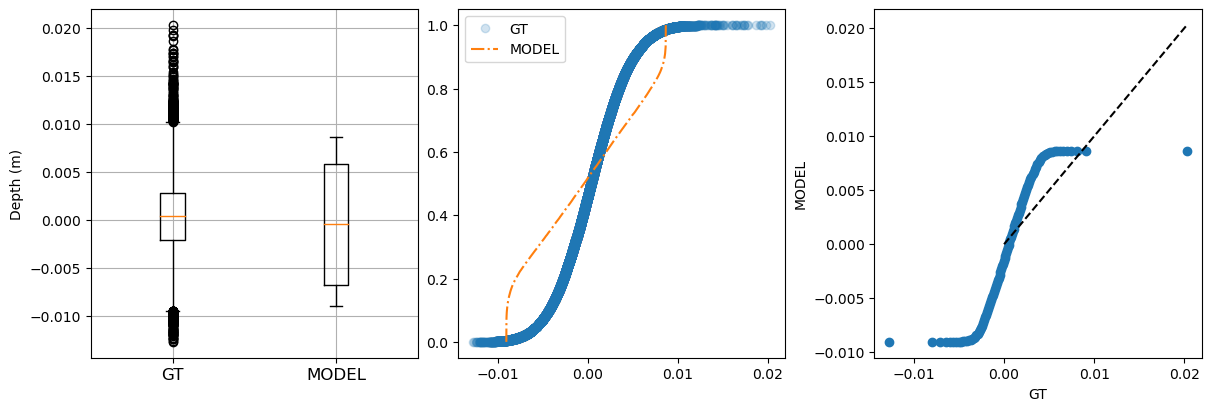

In [32]:
qqplot(its_inp[idx].ravel(), its_gen[idx].ravel(), quantiles=100)